<a href="https://colab.research.google.com/github/TianyiZhang-zzz/SupplyChain/blob/main/CaLNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [30]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)


In [31]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [32]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [33]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


# Decision Variables

In [34]:
# decision variables
calng_price = 7.50 # set by CaLNG

peak_intake_from_pipeline = 181

# Utility (Actual Usage)

In [35]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [36]:
# get usage data
usage_data = determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, 1288)

# inspect usage_data (round to 2 decimal places)
np.round(usage_data,2)

,price_index,Month,Date,Demand,pipeline_price,cost_from_pipeline_only,demand_for_lng,purchase_from_calng,pipeline_intake,pipeline_intake_price,cost_from_both,savings
0,0,December,1,94,1.00,94.00,0,0,94,1.00,94.00,0.00
1,1,December,2,304,14.39,4375.14,123,123,181,1.85,1257.85,3117.30
2,2,December,3,70,1.00,70.00,0,0,70,1.00,70.00,0.00
3,3,December,4,222,3.67,814.58,41,41,181,1.85,642.85,171.74
4,4,December,5,123,1.00,123.00,0,0,123,1.00,123.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,February,25,52,1.00,52.00,0,0,52,1.00,52.00,0.00
87,87,February,26,39,1.00,39.00,0,0,39,1.00,39.00,0.00
88,88,February,27,109,1.00,109.00,0,0,109,1.00,109.00,0.00
89,89,February,28,250,5.85,1462.83,69,69,181,1.85,852.85,609.98


In [37]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase, return_data=False):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake = sum(cost_data['pipeline_intake'])
    total_calng_intake = sum(cost_data['purchase_from_calng'])

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase*calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    total_savings = sum(cost_data['savings']) * 1000

    average_demand = np.mean(cost_data['Demand'])
    average_price = math.exp(max(0, (average_demand - 144)/60))

    total_average_draw_daily = sum(cost_data['Demand']) * average_price * 1000

    if not return_data:
        print(f"CaLNG price: ${calng_price:<04}")

        print("---")
        print(f"Peak intake from pipeline: {peak_intake_from_pipeline:,.0f} MMcf")
        print(f"Total peak months intake from pipeline: {total_pipeline_intake:,.0f} MMcf")
        print(f"Total intake from CaLNG: {total_calng_intake:,.0f} MMcf")

        print("---")
        print(f"Total amount paid to pipeline: ${total_pipeline_intake_cost:,.0f}")
        print(f"Total amount paid to CaLNG: ${total_calng_intake_cost:,.0f}")
        print(f"Total cost for utility: ${total_utility_cost:,.0f}")
        print(f"Savings from using CaLNG: ${total_savings:,.0f}")

        print("---")
        print(f"Total cost if average draw daily: ${total_average_draw_daily:,.0f}")

    else:
        cost_stat_dict = {
            "peak_intake_from_pipeline": peak_intake_from_pipeline,
            "total_lng_purchase": total_lng_purchase,
            "total_pipeline_intake": total_pipeline_intake,
            "total_calng_intake": total_calng_intake,
            "total_pipeline_intake_cost": total_pipeline_intake_cost,
            "total_calng_intake_cost": total_calng_intake_cost,
            "total_utility_cost": total_utility_cost,
            "total_savings": total_savings,
            "total_average_draw_daily": total_average_draw_daily
        }

        return cost_stat_dict

# Demand

In [39]:
# demand randomization parameters
mean_daily_demand = 144
std_dev_daily_demand = 59

#decision variables
total_lng = 1200
peak_intake_from_pipeline = 180

Optimal Total LNG: 750, Optimal Peak Pipeline Intake: 180


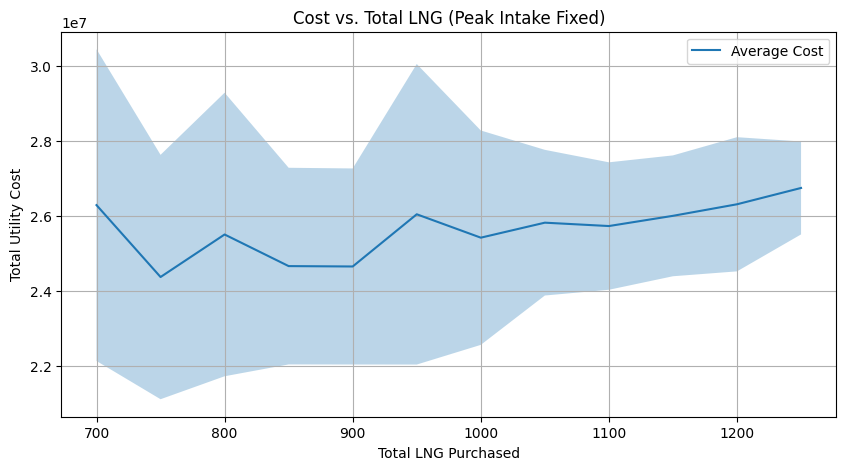

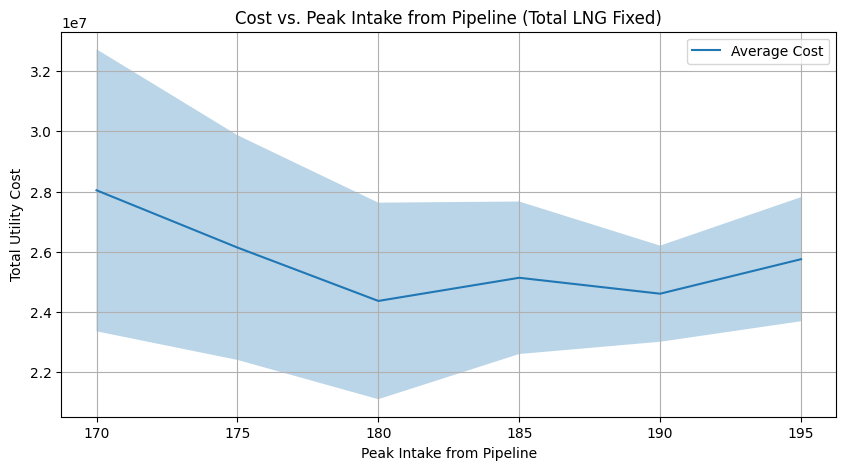

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define simulation parameters
num_draws = 50  # Increased number of simulation draws per scenario
total_lng_range = range(700, 1300, 50)  # LNG purchase range
peak_intake_from_pipeline_range = range(170, 200, 5)  # Pipeline intake range

# Store results
cost_stat_list = []

# Run simulations
for total_lng in total_lng_range:
    for peak_intake in peak_intake_from_pipeline_range:
        sims = []
        for _ in range(num_draws):
            # Simulate demand data
            sim_demand_data = demand_data.copy()
            demand_sample = np.round(np.random.normal(144, 59, len(sim_demand_data)))
            demand_sample = np.where(demand_sample < 0, 0, demand_sample)
            sim_demand_data['Demand'] = demand_sample

            # Compute costs for this scenario
            sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak_intake, total_lng)
            cost_stat_dict = calculate_cost_statistics(sim_usage_data, calng_price, peak_intake, total_lng, return_data=True)

            sims.append(cost_stat_dict)

        # Store average results
        avg_results = pd.DataFrame(sims).mean()
        avg_results["std_dev_cost"] = pd.DataFrame(sims)["total_utility_cost"].std()  # Capture std deviation
        cost_stat_list.append(avg_results)

# Convert to DataFrame
df = pd.DataFrame(cost_stat_list)

# Find optimal pair (total_LNG, peak_intake_from_pipeline) that minimizes cost
optimal_row = df.loc[df["total_utility_cost"].idxmin()]
optimal_total_LNG = int(optimal_row["total_lng_purchase"])
optimal_peak_intake = int(optimal_row["peak_intake_from_pipeline"])

print(f"Optimal Total LNG: {optimal_total_LNG}, Optimal Peak Pipeline Intake: {optimal_peak_intake}")

# --- PLOTTING SECTION ---

# 1st Plot: Cost vs. total_LNG (keeping peak_intake_from_pipeline optimal)
subset_lng = df[df["peak_intake_from_pipeline"] == optimal_peak_intake]
plt.figure(figsize=(10, 5))
plt.plot(subset_lng["total_lng_purchase"], subset_lng["total_utility_cost"], label="Average Cost")
plt.fill_between(subset_lng["total_lng_purchase"],
                 subset_lng["total_utility_cost"] - subset_lng["std_dev_cost"],
                 subset_lng["total_utility_cost"] + subset_lng["std_dev_cost"],
                 alpha=0.3)
plt.xlabel("Total LNG Purchased")
plt.ylabel("Total Utility Cost")
plt.title("Cost vs. Total LNG (Peak Intake Fixed)")
plt.legend()
plt.grid(True)
plt.show()

# 2nd Plot: Cost vs. peak_intake_from_pipeline (keeping total_LNG optimal)
subset_pipeline = df[df["total_lng_purchase"] == optimal_total_LNG]
plt.figure(figsize=(10, 5))
plt.plot(subset_pipeline["peak_intake_from_pipeline"], subset_pipeline["total_utility_cost"], label="Average Cost")
plt.fill_between(subset_pipeline["peak_intake_from_pipeline"],
                 subset_pipeline["total_utility_cost"] - subset_pipeline["std_dev_cost"],
                 subset_pipeline["total_utility_cost"] + subset_pipeline["std_dev_cost"],
                 alpha=0.3)
plt.xlabel("Peak Intake from Pipeline")
plt.ylabel("Total Utility Cost")
plt.title("Cost vs. Peak Intake from Pipeline (Total LNG Fixed)")
plt.legend()
plt.grid(True)
plt.show()
